# Tully-Fisher Secondary Target Sample: Coma Cluster

Access secondary PV survey targets intended for TF measurements.

Grab the targets from the Coma cluster and see if we can calibrate the TFR.

In [2]:
import os
import requests

from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from desispec.spectra import stack as specstack
from desispec.io import read_spectra, write_spectra

import psycopg2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
mpl.rc('font', size=12)
mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning=0)

## Postgres Query

See if we have a cached copy of the query results (in FITS format) before running this query.

For connecting to the database, it is recommended that you store the password and connection port in a secure `.pgpass` file on the system or create a private INI file that is not committed to GitHub.  Connection details are not going to be saved in this notebook.  Ask on the `#timedomain-general` or `#peculiar-velocity` or `#transients-lowzcosmo-general` slack channels for more information.

See the [database wiki page](https://desi.lbl.gov/trac/wiki/DESIDatabase) for information about the location and names of tables and their schema.

In [9]:
# Change use_cached = False if we want to redo the query at some point.
use_cached = True

if os.path.exists('cache/tf_targets_everest.fits') and use_cached:
    tf_targets = Table.read('cache/tf_targets_everest.fits')
else:
    try:
        db = psycopg2.connect(host='decatdb.lbl.gov', database='desi', user='desi')
        cursor = db.cursor()
        
        query = """SELECT DISTINCT pr.pvtype, pr.sga_id, fd.targetid, fd.fiber_ra, fd.fiber_dec, fd.fiberstatus, fd.tileid, zd.target_ra, zd.target_dec, zd.z, zd.zerr, zd.spectype, zd.deltachi2, zd.zwarn
                   FROM everest.ztile_cumulative_fibermap fd
                   INNER JOIN
                       everest.ztile_cumulative_redshifts zd ON zd.targetid = fd.targetid
                   INNER JOIN pv.proposals pr ON (CAST(pr.ra*10000 AS INTEGER) = CAST(zd.target_ra*10000 AS INTEGER)) AND 
                                                 (CAST(pr.dec*10000 AS INTEGER) = CAST(zd.target_dec*10000 AS INTEGER))
                   WHERE (pr.pvtype LIKE 'TFT' or pr.pvtype LIKE 'EXT' or pr.pvtype LIKE 'SGA');"""
        
        cursor.execute(query)
        rows = cursor.fetchall()
        tf_targets = Table(list(map(list, zip(*rows))), 
                           names=['PVTYPE', 'SGA_ID', 'TARGETID', 'FIBER_RA', 'FIBER_DEC', 'FIBERSTATUS', 'TILEID', 
                                  'TARGET_RA', 'TARGET_DEC', 'Z', 'ZERR', 'SPECTYPE', 'DELTACHI2', 'ZWARN'])
        tf_targets.write('cache/tf_targets_everest.fits', overwrite=True)
        
    except (Exception, psycopg2.errors) as error:
        print(error)
    finally:
        if db is not None:
            db.close()
            
tf_targets

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN
str3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,str6,float64,int64
EXT,17643,39633062056692288,0.0,0.0,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163671928495,39.2330481232594,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163676763292,39.2330716810911,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163687172584,39.2330595735952,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163687272099,39.2330517354585,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163687614895,39.2330239448729,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163692746003,39.2330238257014,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163702566258,39.2330592761066,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163702811737,39.2330394673576,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0


In [10]:
if 'FIBERSTATUS' in tf_targets.colnames:
    tf_targets = tf_targets[tf_targets['FIBERSTATUS'] == 0]
    print(len(tf_targets))

46307


In [11]:
np.unique(tf_targets['PVTYPE'], return_counts=True)

(<Column name='PVTYPE' dtype='str3' length=3>
 EXT
 SGA
 TFT,
 array([ 1299, 14686, 30322]))

In [12]:
coma_cluster = ((tf_targets['TILEID'] <= 135) & (tf_targets['TILEID'] >= 109)) | ((tf_targets['TILEID'] <= 456) & (tf_targets['TILEID'] >= 454))

np.sum(coma_cluster)

tf_coma_targets = tf_targets[coma_cluster]

## Plot target coordinates

In [13]:
def plot_radec(table):
    '''
    Mollweide projection plot adapted to astro coordinates.
    
    
    PARAMETERS
    ==========
    
    table : astropy.table.Table
        Data table with secondary target info
        
    
    RETURNS
    =======
    
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation
    '''
    
    fig, ax = plt.subplots(1,1, 
                           figsize=(8,4), 
                           subplot_kw={'projection':'mollweide'})
    
    ############################################################################
    # Loop through unique classes
    #---------------------------------------------------------------------------
    class_names = np.unique(table['PVTYPE'])
    
    for class_name in class_names:
        select = table['PVTYPE'] == class_name
        
        ########################################################################
        # Convert ra,dec to radians
        # Rotate the ra so that the plot goes 360->0 left to right
        #-----------------------------------------------------------------------
        _ra = np.radians(180. - table['TARGET_RA'][select])
        _dec = np.radians(table['TARGET_DEC'][select])
        ########################################################################
        
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)
    ############################################################################
    
    
    ############################################################################
    # Clean up the plot
    #---------------------------------------------------------------------------
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]), 
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()
    ############################################################################
    
    return fig;

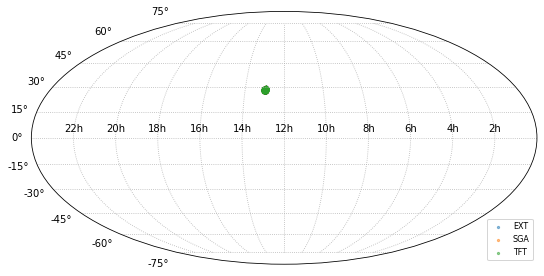

In [14]:
fig = plot_radec(tf_coma_targets)

## Plot target redshifts

Extract good redshifts and plot the distributions as a function of target type.

In [15]:
isgoodz = (tf_coma_targets['DELTACHI2'] >= 25) & (tf_coma_targets['ZWARN'] == 0)
# isgoodz = tf_coma_targets['ZWARN'] == 0
np.sum(isgoodz)

1375

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


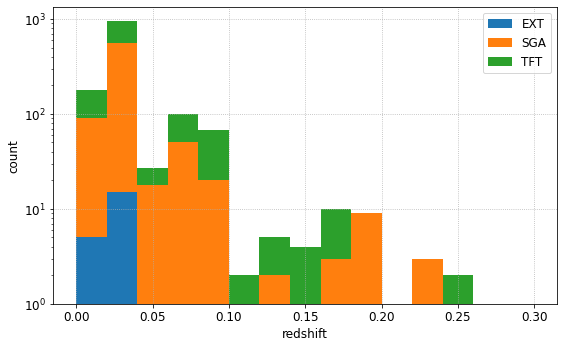

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []

pvtypes = np.unique(tf_coma_targets['PVTYPE'])

for pvtype in pvtypes:
    
    ispvtype = tf_coma_targets['PVTYPE'] == pvtype
    
    zdata.append(list(tf_coma_targets['Z'][isgoodz & ispvtype]))
    
zbins = np.linspace(0,0.3, 16)

ax.hist(zdata, bins=zbins, stacked=True, log=True, label=pvtypes)

ax.set(#ylim=(0,15), 
       xlabel='redshift', 
       ylabel='count')
ax.grid(ls=':')

ax.legend(fontsize=12);

## Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

For the Coma cluster, these values are [(Tully 2015)](https://ui.adsabs.harvard.edu/abs/2015AJ....149..171T/abstract):
- $(supergalactic longitude, supergalactic latitude)_{Coma} = (89.6226^\circ, 8.1461^\circ)$
- $R_{2t} = 2.129$ Mpc/$h$
- $\sigma_p = 1045$ km/s
- $V_c = $ km/s